In [1]:
import os
os.chdir('..')

In [2]:
import json
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import groupby
from collections import defaultdict

## Per-station metrics

In [3]:
with open('results/two_week/station_metrics.json', 'r') as file:
    two_week_station_data = json.load(file)

with open('results/four_week/station_metrics.json', 'r') as file:
    four_week_station_data = json.load(file)

In [4]:
def extract_metrics(station_data, model_name):
    metrics = {}
    for metric in ['rmse', 'mae', 'mbe']:
        value_mean = station_data.get(f'{model_name}_{metric}_mean', '---')
        value_std = station_data.get(f'{model_name}_{metric}_std', '---')
        
        if value_std == 0:
            value_std = '---'

        metrics[f'{metric}_mean'] = '{:.2f}'.format(value_mean) if isinstance(value_mean, (float, int)) else value_mean
        metrics[f'{metric}_std'] = '{:.2f}'.format(value_std) if isinstance(value_std, (float, int)) else value_std

    return metrics

def fill_table(station_name, two_week_station_data, four_week_station_data):
    models = {
        'mlp': 'MLP',
        'baseline': 'Richard et al.',
        'gapt_naive': 'GapT (naive)',
        'gapt': 'GapT'
    }
    table_data = []

    for sequence, data in [('2 weeks', two_week_station_data), ('4 weeks', four_week_station_data)]:
        for model_key, model_name in models.items():
            metrics = extract_metrics(data.get(station_name, {}), model_key)
            table_data.append((station_name, sequence, model_name, 
                               metrics['rmse_mean'], metrics['rmse_std'], 
                               metrics['mae_mean'], metrics['mae_std'], 
                               metrics['mbe_mean'], metrics['mbe_std']))

    return table_data

# Fetch stations from two_week_station_data
stations = sorted(list(two_week_station_data.keys()))
full_table_data = []

for station in stations:
    full_table_data.extend(fill_table(station, two_week_station_data, four_week_station_data))

# Create grouped data for highlighting
grouped_data = {}
for data in full_table_data:
    station = data[0]
    sequence = data[1]
    grouped_data.setdefault(station, {}).setdefault(sequence, []).append(data)

# Calculate the lowest values for highlighting
lowest_values = {}
for station, sequences in grouped_data.items():
    lowest_values[station] = {}
    for sequence, entries in sequences.items():
        # Filter out '---' entries before converting to float and finding the minimum
        min_rmse_mean = min([float(entry[3]) for entry in entries if entry[3] != '---'], default='---')
        min_rmse_std = min([float(entry[4]) for entry in entries if entry[4] != '---'], default='---')
        
        min_mae_mean = min([float(entry[5]) for entry in entries if entry[5] != '---'], default='---')
        min_mae_std = min([float(entry[6]) for entry in entries if entry[6] != '---'], default='---')
        
        # Determine the MBE mean closest to zero
        mbe_means = [float(entry[7]) for entry in entries if entry[7] != '---']
        closest_mbe_mean = min(mbe_means, key=lambda x: abs(x), default='---') if mbe_means else '---'
        min_mbe_std = min([float(entry[8]) for entry in entries if entry[8] != '---'], default='---')
        
        lowest_values[station][sequence] = (min_rmse_mean, min_rmse_std, min_mae_mean, min_mae_std, closest_mbe_mean, min_mbe_std)

with open('results/station_metrics.tex', 'w') as out_file:
    out_file.write('\\begin{longtable}{cllcccccc}\n')
    out_file.write('\t\\caption{Results.} \\\\\n') # Caption for the first page
    out_file.write('\t\\hline\n')
    out_file.write('\tStation & Sequence & Model & \\multicolumn{2}{c}{RMSE ($\\text{cm}^{-3}$)} & \\multicolumn{2}{c}{MAE ($\\text{cm}^{-3}$)} & \\multicolumn{2}{c}{MBE ($\\text{cm}^{-3}$)} \\\\\n')
    out_file.write('\t& & & mean & std & mean & std & mean & std \\\\\n')
    out_file.write('\t\\hline\n')
    out_file.write('\t\\endfirsthead \n') # End the first header
    
    out_file.write('\t\\caption{Results (continued).} \\\\\n') # Caption for continued pages
    out_file.write('\t\\hline\n')
    out_file.write('\tStation & Sequence & Model & \\multicolumn{2}{c}{RMSE ($\\text{cm}^{-3}$)} & \\multicolumn{2}{c}{MAE ($\\text{cm}^{-3}$)} & \\multicolumn{2}{c}{MBE ($\\text{cm}^{-3}$)} \\\\\n')
    out_file.write('\t& & & mean & std & mean & std & mean & std \\\\\n')
    out_file.write('\t\\hline\n')
    out_file.write('\t\\endhead \n')
    
    
    prev_station = None
    model_count = 0
    sequence_count = 0
    station_count = 0

    for station, sequences in grouped_data.items():
        station_count += 1

        if prev_station is not None:
            out_file.write('\t\\hline\n')

        out_file.write('\t\\multirow{8}{*}{' + station + '}\n')
        prev_station = station
        for sequence, entries in sequences.items():
            for entry in entries:
                _, _, model, rmse_mean, rmse_std, mae_mean, mae_std, mbe_mean, mbe_std = entry
                min_values = lowest_values[station][sequence]

                out_file.write('\t& \\multirow{4}{*}{' + sequence + '}' if model_count == 0 else '\t&')
                out_file.write(' & {}'.format(model))

                for idx, val in enumerate([rmse_mean, rmse_std, mae_mean, mae_std, mbe_mean, mbe_std]):
                    # Check if both the value and min_values can be converted to floats
                    try:
                        float_val = float(val)
                        min_val = float(min_values[idx])
                        is_min = float_val == min_val
                    except ValueError:
                        # Either 'val' or 'min_values[idx]' is '---'
                        is_min = val == min_values[idx]

                    if is_min:
                        out_file.write(' & \\textbf{' + val + '}')
                    else:
                        out_file.write(' & ' + val)

                out_file.write(' \\\\\n')
                model_count += 1
                if model_count == 4:
                    model_count = 0
                    sequence_count += 1
                    if sequence_count == 1:
                        # Add cline between 2 weeks and 4 weeks sequences
                        out_file.write('\t\\cline{2-9}\n')
        sequence_count = 0

        # Add pagebreak after every 5 stations
        if station_count % 6 == 0:
            out_file.write('\t\\hline\n')
            out_file.write('\t\\pagebreak\n')


    out_file.write('\t\\hline\n')
    out_file.write('\t\\label{tab:station_metrics}\n')
    out_file.write('\\end{longtable}\n')

## Overall metrics

In [5]:
with open('results/two_week/metrics.json', 'r') as file:
    two_week_data = json.load(file)

with open('results/four_week/metrics.json', 'r') as file:
    four_week_data = json.load(file)

In [6]:
model_name_mapping = {
    "mlp": "MLP",
    "baseline": "Richard et al.",
    "gapt_naive": "GapT (naive)",
    "gapt": "GapT"
}

params = {
    "MLP": "867k",
    "Richard et al.": "804k",
    "GapT (naive)": "820k",
    "GapT": "818k"
}

def best_values(data, metrics):
    best = {}
    for metric in metrics:
        if 'mbe' in metric or 'nmbe' in metric:  # include nmbe
            best[metric] = min(data, key=lambda k: abs(data[k][metric]))
        else:
            best[metric] = min(data, key=lambda k: data[k][metric])
    return best

def format_metric_value(metric, value):
    """Format metric values based on their type (unit or percentage)."""
    if "nrmse" in metric or "nmae" in metric or "nmbe" in metric:
        return f"{value * 100:.2f}"
    return f"{value:.2f}"

# Adjust the LaTeX row generation function
def generate_latex_rows(data, sequence_name):
    rows = []
    metrics_list = ['rmse_mean', 'rmse_std', 'mae_mean', 'mae_std', 'mbe_mean', 'mbe_std',
                    'nrmse_mean', 'nrmse_std', 'nmae_mean', 'nmae_std', 'nmbe_mean', 'nmbe_std']
    best_metrics = best_values(data, metrics_list)
    
    for model_key, model_data in data.items():
        model_name = model_name_mapping[model_key]
        row = f'& {model_name} & {params[model_name]}'
        for metric in metrics_list:
            formatted_value = format_metric_value(metric, model_data[metric])
            if model_key == best_metrics[metric]:
                row += f' & \\textbf{{{formatted_value}}}'
            else:
                row += f' & {formatted_value}'
        row += ' \\\\'
        rows.append(row)
    return "\n".join(rows)

# Update the LaTeX table template
latex_table = r"""
\begin{table}
\caption{Results.}
\label{tab:results}
    \begin{adjustbox}{width=\textwidth,center}
	\begin{tabular}{clcccccccccccccccccc}
	\hline
Sequence & Model & \# Params & \multicolumn{2}{c}{RMSE ($\text{cm}^{-3}$)} & \multicolumn{2}{c}{MAE ($\text{cm}^{-3}$)} & \multicolumn{2}{c}{MBE ($\text{cm}^{-3}$)} & \multicolumn{2}{c}{nRMSE (\%)} & \multicolumn{2}{c}{nMAE (\%)} & \multicolumn{2}{c}{nMBE (\%)} \\ 
	 &  &  & mean & std & mean & std & mean & std & mean & std & mean & std & mean & std \\ 
	\hline
	\multirow4{*}{2 weeks}
""" + generate_latex_rows(two_week_data, "2 weeks") + r"""
	\hline
	\multirow4{*}{4 weeks}
""" + generate_latex_rows(four_week_data, "4 weeks") + r"""
	\hline
	\end{tabular}
    \end{adjustbox}
\end{table}
"""

# Save to the specified file
with open('results/metrics.tex', 'w') as file:
    file.write(latex_table)

## Load predictions for all stations

In [7]:
def load_station_data(seq):
    with open(f'results/{seq}/station_metrics.pkl', 'rb') as f:
        metrics_by_key = pickle.load(f)
        
    with open(f'results/{seq}/station_metrics.json', 'r') as file:
        station_data = json.load(file)

    metrics_by_key = defaultdict(lambda: defaultdict(list), metrics_by_key)
    
    all_data = []

    # Loop over each model and its metrics
    for model, metrics in metrics_by_key.items():
        for metric_name, values in metrics.items():
            if metric_name != 'target_values':  # We exclude target_values as per your previous code
                # Append data for each metric in the model
                for value in values:
                    all_data.append({
                        'model': model,
                        'metric': metric_name,
                        'value': value
                    })

    # Convert the data list into a DataFrame
    df = pd.DataFrame(all_data)
    df['model'] = df['metric'].str.extract('(mlp|baseline|gapt_naive|gapt)')
    df['metric'] = df['metric'].str.replace('(mlp|baseline|gapt_naive|gapt)_', '', regex=True)
    
    # Create a list to hold the normalized data
    normalized_data = []
    # Loop over each station in station_data
    for station, metrics in station_data.items():
        avg_target_value = metrics["average_target"]

        for metric_key, value in metrics.items():
            if metric_key != "average_target": # Exclude the average_target key

                # Extract model and metric type
                for possible_model in ['mlp', 'baseline', 'gapt_naive', 'gapt']:
                    if possible_model in metric_key:
                        model = possible_model
                        break

                metric_type = metric_key.replace(f"{model}_", "").replace("_mean", "")

                # Normalize the metric values
                if metric_type == "rmse":
                    nvalue = value / avg_target_value
                    normalized_data.append({
                        "station": station,
                        "model": model,
                        "metric": "nrmse",
                        "value": nvalue
                    })
                elif metric_type == "mae":
                    nvalue = value / avg_target_value
                    normalized_data.append({
                        "station": station,
                        "model": model,
                        "metric": "nmae",
                        "value": nvalue
                    })
                elif metric_type == "mbe":
                    nvalue = value / avg_target_value
                    normalized_data.append({
                        "station": station,
                        "model": model,
                        "metric": "nmbe",
                        "value": nvalue
                    })
    ndf = pd.DataFrame(normalized_data)

    return df, ndf

In [8]:
two_week_df, two_week_ndf = load_station_data('two_week')

In [9]:
four_week_df, four_week_ndf = load_station_data('four_week')

## Plot boxplot distribution of metrics

In [10]:
import colorsys
import matplotlib.colors

def adjust_lightness(color, factor=1.1):
    """Adjust the lightness of an RGB color. Provide a factor > 1 to lighten the color."""
    h, l, s = colorsys.rgb_to_hls(*[x/255.0 for x in matplotlib.colors.to_rgb(color)])
    l = min(max(l * factor, 0), 1)
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    r, g, b = r*255, g*255, b*255
    r, g, b = min(r, 1), min(g, 1), min(b, 1)
    return (r, g, b)

In [11]:
def plot_bars(df):
    sns.set_style('whitegrid')

    # Rename metrics for display
    rename_metrics = {
        'rmse': 'RMSE',
        'mae': 'MAE',
        'mbe': 'MBE',
        'nrmse': 'nRMSE',
        'nmae': 'nMAE',
        'nmbe': 'nMBE'
    }
    df['metric'] = df['metric'].map(rename_metrics).fillna(df['metric'])

    # Set order for the models and metrics
    model_order = ['mlp', 'baseline', 'gapt_naive', 'gapt']
    model_names = ['MLP', 'Richard et al.', 'GapT (naive)', 'GapT']
    colors = [adjust_lightness(col) for col in ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']]


    # Plotting
    plt.figure(figsize=(7.5, 5))
    sns.boxplot(x='metric', y='value', hue='model', data=df, saturation=1, hue_order=model_order, palette=colors, showfliers=False)
    plt.xlabel('Metric')
    plt.ylabel('Value')

    # Setting custom legend labels
    handles, _ = plt.gca().get_legend_handles_labels()
    plt.legend(handles, model_names)

    # Turn on the spines
    ax = plt.gca()
    for position in ['left', 'right', 'top', 'bottom']:
        ax.spines[position].set_visible(True)
        ax.spines[position].set_color('black')
    # Turn on major ticks
    ax.tick_params(which='major', direction='out', left=True, bottom=True)

    plt.tight_layout()
    plt.show()

In [12]:
# plot_bars(two_week_df)
# plot_bars(two_week_ndf)
# plot_bars(four_week_df)
# plot_bars(four_week_ndf)

In [13]:
def load_metrics(seq):
    with open(f'results/{seq}/station_metrics.pkl', 'rb') as f:
        metrics_by_key = pickle.load(f)
    return metrics_by_key

def normalize_rmse(metrics_by_key):
    normalized_data = []

    for station, metrics in metrics_by_key.items():
        for model in ['baseline', 'gapt']:
            metric_key = f'{model}_rmse'
            target_mean = np.mean(metrics['target_values'])
            normalized_values = [(value/target_mean)*100 for value in metrics.get(metric_key, [])]

            for value in normalized_values:
                normalized_data.append({
                    'station': station,
                    'model': model,
                    'nrmse': value
                })

    return pd.DataFrame(normalized_data)

In [14]:
seq = 'two_week'
metrics_by_key = load_metrics(seq)
two_week_ndf = normalize_rmse(metrics_by_key)

seq = 'four_week'
metrics_by_key = load_metrics(seq)
four_week_ndf = normalize_rmse(metrics_by_key)

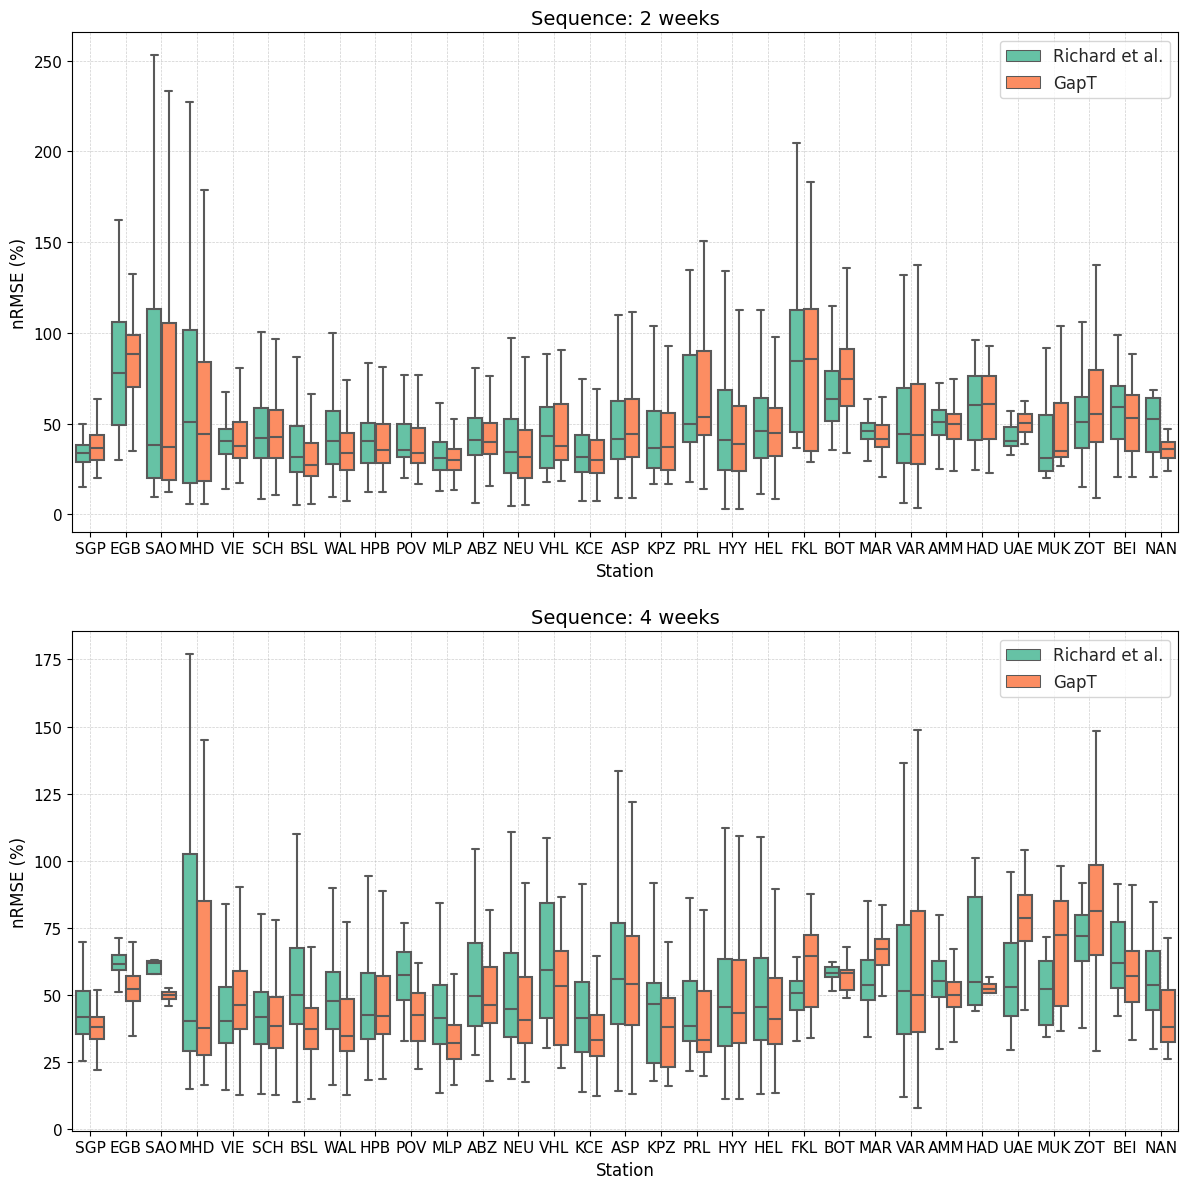

In [15]:
import matplotlib.ticker as ticker

def plot_normalized_rmse(ax, ndf, title):
    with open('data/measurement_sites.json', 'r') as file:
        measurement_sites = pd.read_json(file)
    ordered_stations = measurement_sites.T.sort_values(by='longitude').index.intersection(ndf['station'].unique()).tolist()

    sns.set_style('whitegrid')
    
    model_order = ['baseline', 'gapt']
    model_names = ['Richard et al.', 'GapT']
    
    # Subtle, colorblind-friendly palette
    colors = ['#1f77b4', '#ff7f0e']
    colors = [adjust_lightness(col) for col in ['tab:blue', 'tab:orange']]
    colors = plt.cm.Set2.colors

    # Create a boxplot
    sns.boxplot(x='station', y='nrmse', hue='model', data=ndf, order=ordered_stations,
                hue_order=model_order, palette=colors, showfliers=False,
                saturation=1, ax=ax)
    
    # Title and labels
    ax.set_ylabel('nRMSE (%)', fontsize=12)
    ax.set_xlabel('Station', fontsize=12)
    
    # Setting custom legend labels
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles, model_names, fontsize=12)

    # Spines & ticks
    for position in ['left', 'right', 'top', 'bottom']:
        ax.spines[position].set_visible(True)
        ax.spines[position].set_color('black')
    # Turn on major ticks
    ax.tick_params(which='major', direction='out', left=True, bottom=True, labelsize=11)
    
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
    ax.set_axisbelow(True)
    
    ax.set_title(title, fontsize=14)
    

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

plot_normalized_rmse(axes[0], two_week_ndf, 'Sequence: 2 weeks')
plot_normalized_rmse(axes[1], four_week_ndf, 'Sequence: 4 weeks')

plt.tight_layout()

plt.subplots_adjust(hspace=0.2)
plt.savefig('figures/station_nrmse.pdf')
plt.savefig('figures/station_nrmse.png')

plt.show()